In [2]:
import jailbreakbench as jbb
import os
import pandas as pd

import numpy as np
from sklearn.svm import SVC
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from SPD.main_spd import calculate_logits
import litellm
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [224]:
#from datasets import load_dataset
#import json
#ds = load_dataset("SetFit/qnli")

Repo card metadata block was not found. Setting CardData to empty.


In [3]:
litellm.set_verbose = False

In [4]:
#import logging
#logging.getLogger("litellm").setLevel(logging.ERROR)

In [5]:
%load_ext autoreload
%autoreload 2

### 1. Save the logits
For each dataset, calculate and save logit values in seperate folders. Hyperparameters such as temperature, top-p, top-k can be modified by altering the SPD/config_spd.py file.

In [260]:
# Location to save the data
write_path = "logits/gcg/test"

model_name = "gpt-4o-mini"

# Load the data from JSON
data_path = "data/GPT4o/GCG.json" 
data = pd.read_json(path_or_buf=data_path)[model_name]#["gpt-3.5-turbo-0613"]

# Load data from csv
#data_path = "data/GPT3.5/promptDatasetGPT.csv"
#data = pd.read_csv(data_path)
#data = data[data["Success"] == True]
#data = data.rename(columns={"Successful Prompt": "prompt"})
#data = data[['prompt']].apply(lambda x: x.to_dict(), axis=1)
#data = data.reset_index(drop=True)
#data.name = "gpt-3.5-turbo-0613"


ind_to_read = [*range(160, 561)] 
prompts = {}
for i in range(len(ind_to_read)):
    prompts[i] = data[ind_to_read[i]]["prompt"]

all_prompts = {model_name: prompts}
    
# Saves the logit values in write_path/model_name
logits = calculate_logits(write_path, all_prompts, llm_provider="litellm")

Querying responses for gpt-4o-mini.


In [261]:
logits.shape

(378, 25, 5)

In [74]:
# DO NOT RUN CELL

#jailbroken_logits = []

In [99]:
jailbroken_logits.append(logits)

In [100]:
#len(jailbroken_logits)
len(jailbroken_logits)

4

In [102]:
combined_logits = np.concatenate([jailbroken_logits[0], jailbroken_logits[1], jailbroken_logits[2], jailbroken_logits[3]], axis=0)

In [103]:
combined_logits.shape

(320, 25, 5)

In [155]:
#jailbroken_logits[0]

In [106]:
train_logits, test_logits = train_test_split(combined_logits, test_size=0.2)

In [108]:
train_logits.shape

(256, 25, 5)

In [109]:
test_logits.shape

(64, 25, 5)

In [110]:
folder_path = "jailbroken_logits"
# Save train and test logits as .npy files
np.save(os.path.join(folder_path, "train_logits.npy"), train_logits)
np.save(os.path.join(folder_path, "test_logits.npy"), test_logits)

In [233]:
# Location to save the data BENIGN PROMPTS
# Load the data
model_name = "gpt-4o-mini"
data_path = "data/GPT4o/benign_outputs.json" 
data = pd.read_json(path_or_buf=data_path)
# shuffle data
data = data.sample(frac=1).reset_index(drop=True)

In [238]:
write_path = "logits/benign1/test"
ind_to_read = [*range(400, 796)] 
prompts = {}
for i in range(len(ind_to_read)):
    prompts[i] = data.iloc[ind_to_read].iloc[i]["instruction"]

all_prompts = {model_name: prompts}
    
# Saves the logit values in write_path/model_name
logits = calculate_logits(write_path, all_prompts, llm_provider="litellm")

Querying responses for gpt-4o-mini.


In [245]:
data_path = "data/GPT4o/qnli_1000.json"
data = pd.read_json(path_or_buf=data_path)
# shuffle data
data = data.sample(frac=1).reset_index(drop=True)

In [251]:
# QNLI dataset loading
write_path = "logits/benign2/test"
ind_to_read = [*range(500, 1000)] 
prompts = {}
for i in range(len(ind_to_read)):
    prompts[i] = data.iloc[ind_to_read].iloc[i]["text1"]

all_prompts = {model_name: prompts}
    
# Saves the logit values in write_path/model_name
logits = calculate_logits(write_path, all_prompts, llm_provider="litellm")

Querying responses for gpt-4o-mini.


In [252]:
logits.shape

(494, 25, 5)

In [248]:
prompts

{0: 'Who is a professor of civil and environmental engineering at Stanford University?'}

In [ ]:
logits.shape

### 2. Load training data

Load the saved logit values and prepare the feature vector. While $r$ determines the number of token locations, $k$ determines how many candidates are calculated per each location.

In [9]:
model_name = "gpt-4o-mini"

#train_size = 80

r = 25   # Number of token places to consider
k = 5  # Number of candidate logit values to consider

# Locations of the train data
read_paths_train = ["logits/benign1/train",
                    "logits/benign2/train",
                    "logits/pair/train",
                    "logits/gcg/train"]

#read_paths_train = ["logits/benign/train",
#                    "logits/pair/train"]



logit_values_train = []

# Finding minimum train size dynamically in case of imbalanced classes
train_sizes = []
for path in read_paths_train:
    logits = np.load(os.path.join(path, f"{model_name}.npy"))
    train_sizes.append(logits.shape[0])  # Number of available samples


for path in read_paths_train:
    logits = np.load(os.path.join(path, f"{model_name}.npy"))
    probabilities = softmax(logits, axis=2)
    values = - np.log(probabilities)
    logit_values_train.append(values[:train_size,:r,:k].reshape(train_size, r * k))

logit_values_train = np.array(logit_values_train)
benign_indexes = [0]
attack_indexes = [1]

train_benign   = np.concatenate((logit_values_train[benign_indexes]))
train_attack = np.concatenate((logit_values_train[attack_indexes]))
            
train_x = np.concatenate((train_benign,train_attack))
train_y = np.concatenate((np.zeros(train_benign.shape[0]),np.ones(train_attack.shape[0])))    

NameError: name 'train_size' is not defined

In [10]:
# Difference in classes code cell!

BENIGN_PATH_TRAIN = "logits/benign/train"
ATTACK_PATH_TRAIN = "logits/pair/train"

model_name = "gpt-4o-mini"
r = 25   # Number of token positions to consider
k = 5    # Number of candidate logit values to consider

# Two separate lists: one for all benign sets, one for all attacker sets
benign_paths_train = [
    "logits/benign1/train",
    "logits/benign2/train"
]

attack_paths_train = [
    "logits/pair/train",
    "logits/gcg/train"
]

# ------------------------------------------------------------------
# 2. Load and reshape all BENIGN TRAIN data
# ------------------------------------------------------------------
benign_list = []
for path in benign_paths_train:
    # Load logits for this subset
    logits = np.load(os.path.join(path, f"{model_name}.npy"))
    # Convert logits -> probabilities -> negative log probabilities
    probs = softmax(logits, axis=2)
    vals  = -np.log(probs)  # shape: [N, seq_len, vocab_subset?]

    # Slice down to just the first r token positions & top k candidates
    vals = vals[:, :r, :k]  # shape: [N, r, k]

    # Flatten each sample to [r*k]
    benign_list.append(vals.reshape(vals.shape[0], r * k))

# Combine all benign samples from all benign sets
train_benign = np.concatenate(benign_list, axis=0)
print("train_benign shape:", train_benign.shape)

# ------------------------------------------------------------------
# 3. Load and reshape all ATTACK TRAIN data
# ------------------------------------------------------------------
attack_list = []
for path in attack_paths_train:
    logits = np.load(os.path.join(path, f"{model_name}.npy"))
    probs  = softmax(logits, axis=2)
    vals   = -np.log(probs)

    vals = vals[:, :r, :k]
    attack_list.append(vals.reshape(vals.shape[0], r * k))

# Combine all attack samples from all attack sets
train_attack = np.concatenate(attack_list, axis=0)
print("train_attack shape:", train_attack.shape)

# ------------------------------------------------------------------
# 4. Create final training arrays (X, y)
# ------------------------------------------------------------------
train_x = np.concatenate([train_benign, train_attack], axis=0)
train_y = np.concatenate([
    np.zeros(train_benign.shape[0]),  # label=0 for benign
    np.ones(train_attack.shape[0])    # label=1 for attack
])

print("Final train_x shape:", train_x.shape)
print("Final train_y shape:", train_y.shape)


train_benign shape: (890, 125)
train_attack shape: (174, 125)
Final train_x shape: (1064, 125)
Final train_y shape: (1064,)


### 3. Train the classifier

In [11]:
# Train the classifier 
clf = SVC(kernel="rbf",class_weight="balanced")
clf.fit(train_x, train_y) 

SVC(class_weight='balanced')

In [17]:
import pickle
with open("svm_model.pkl", "wb") as f:
    pickle.dump(clf, f)

print("SVM model saved as svm_model.pkl")

SVM model saved as svm_model.pkl


In [18]:
# Load the saved SVM model
with open("svm_model.pkl", "rb") as f:
    clf1 = pickle.load(f)

print("SVM model loaded successfully!")

SVM model loaded successfully!


In [22]:
test_input = np.random.rand(1, 125)  # Assuming input shape (1, 125)
prediction = clf1.predict(test_input)

print("Predicted class:", prediction)

Predicted class: [1.]


In [12]:
#benign_data = np.load(os.path.join("logits/benign/test", f"{model_name}.npy"))
#print("benign_data shape:", benign_data.shape)
#attack_data = np.load(os.path.join("logits/pair/test", f"{model_name}.npy"))
#print("attack_data shape:", attack_data.shape)

benign_data shape: (160, 25, 5)
attack_data shape: (100, 25, 5)


### 4. Load the test data

Load the saved logit values and prepare the feature vector. $r$ and $k$ values should remain the same with training data.

In [198]:
# Locations of the test data
#read_paths_test = ["GPT3.5/logits/benign1/test",
#                    "GPT3.5/logits/benign2/test",
#                    "gpt-3.5/logits/pair/test",
#                    "gpt-3.5/logits/gcg/test"]

read_paths_test = ["logits/benign/test", 
                   "logits/pair/test"]
#test_size = 40

logit_values_test = []

# Finding minimum test size dynamically in case of imbalanced classes
test_sizes = []
for path in read_paths_test:
    logits = np.load(os.path.join(path, f"{model_name}.npy"))
    test_sizes.append(logits.shape[0])  # Number of available samples

test_size = min(test_sizes)

for path in read_paths_test:
    logits = np.load(os.path.join(path, f"{model_name}.npy"))
    probabilities = softmax(logits, axis=2)
    values = - np.log(probabilities)
    
    logit_values_test.append(values[:test_size,:r,:k].reshape(test_size, r * k))

logit_values_test = np.array(logit_values_test)
benign_indexes = [0]
attack_indexes = [1]

test_benign = np.concatenate((logit_values_test[benign_indexes]))
test_attack = np.concatenate((logit_values_test[attack_indexes]))

In [13]:
model_name = "gpt-4o-mini"
r = 25
k = 5

# ------------------------------------------------------------------
# 1. Define the paths where your TEST data (logits) live
# ------------------------------------------------------------------
benign_paths_test = [
    "logits/benign1/test",
    "logits/benign2/test"
]

attack_paths_test = [
    "logits/pair/test",
    "logits/gcg/test"
]

# ------------------------------------------------------------------
# 2. Load and reshape all BENIGN TEST data
# ------------------------------------------------------------------
test_benign_list = []
for path in benign_paths_test:
    logits = np.load(os.path.join(path, f"{model_name}.npy"))
    probs  = softmax(logits, axis=2)
    vals   = -np.log(probs)               # shape: [N, seq_len, vocab_subset?]

    # Keep only first r token positions and top k candidates
    vals = vals[:, :r, :k]                # shape: [N, r, k]
    test_benign_list.append(vals.reshape(vals.shape[0], r * k))

# Combine all benign test samples
test_benign = np.concatenate(test_benign_list, axis=0)
print("test_benign shape:", test_benign.shape)

# ------------------------------------------------------------------
# 3. Load and reshape all ATTACK TEST data
# ------------------------------------------------------------------
test_attack_list = []
for path in attack_paths_test:
    logits = np.load(os.path.join(path, f"{model_name}.npy"))
    probs  = softmax(logits, axis=2)
    vals   = -np.log(probs)

    vals = vals[:, :r, :k]
    test_attack_list.append(vals.reshape(vals.shape[0], r * k))

# Combine all attack test samples
test_attack = np.concatenate(test_attack_list, axis=0)
print("test_attack shape:", test_attack.shape)


test_benign shape: (889, 125)
test_attack shape: (478, 125)


In [14]:
paths = [
    "logits/pair/test",
    "logits/gcg/test"
]

for path in paths:
    path_npy = os.path.join(path, f"{model_name}.npy")
    print("Loading from:", path_npy)
    arr = np.load(path_npy)
    print("Shape of arr:", arr.shape)

Loading from: logits/pair/test\gpt-4o-mini.npy
Shape of arr: (100, 25, 5)
Loading from: logits/gcg/test\gpt-4o-mini.npy
Shape of arr: (378, 25, 5)


### 5. Test the classifier

Get the TP and FP rates of the test data.

In [15]:
pred_benign = clf.predict(test_benign)        
pred_attack = clf.predict(test_attack)        

print('TP rate:', sum(pred_attack)/len(pred_attack) * 100)
print('FP rate:', sum(pred_benign)/len(pred_benign) * 100)

TP rate: 88.07531380753139
FP rate: 9.67379077615298


In [16]:
from sklearn.metrics import f1_score

# 1. Combine all predictions
preds = np.concatenate((pred_benign, pred_attack))

# 2. Create the corresponding ground-truth labels
#    len(pred_benign) benign samples => label=0
#    len(pred_attack) attack samples => label=1
test_y = np.concatenate((
    np.zeros(len(pred_benign)), 
    np.ones(len(pred_attack))
))

# 3. Compute F1 score
f1 = f1_score(test_y, preds)
print("F1 Score:", f1)

F1 Score: 0.8548223350253807


In [267]:
import time


# Suppose you already have your classifier 'clf' trained.
# Suppose you have test_benign and test_attack arrays loaded and reshaped.

# Combine them all into a single array of samples + single array of labels
#   (We only need the samples here for benchmarking, but let's keep the labels for reference)
test_x = np.concatenate([test_benign, test_attack], axis=0)
test_y = np.concatenate([
    np.zeros(test_benign.shape[0]),
    np.ones(test_attack.shape[0])
])

# Option 1: Measure time on a per-sample basis
num_samples = test_x.shape[0]
total_time = 0.0

for i in range(num_samples):
    # Extract the single sample
    sample = test_x[i].reshape(1, -1)  # shape: (1, #features)
    
    start_time = time.time()
    pred = clf.predict(sample)  # Make prediction
    end_time = time.time()
    
    total_time += (end_time - start_time)

avg_time_per_prompt = total_time / num_samples
print("Average time per prompt (single-sample predictions):", avg_time_per_prompt, "seconds")

# Option 2: Measure time on a batch to get a sense of overall speed
# This might be more realistic if you predict many prompts at once
start_time = time.time()
preds = clf.predict(test_x)  # all at once
end_time = time.time()

batch_time = (end_time - start_time)
avg_time_batch = batch_time / num_samples
print("Average time per prompt (batch predictions):", avg_time_batch, "seconds")

Average time per prompt (single-sample predictions): 0.0001909324699016758 seconds
Average time per prompt (batch predictions): 2.9996440806524893e-05 seconds


In [172]:
test_attack

array([[ 0.01830916,  4.14330935,  6.51830935, ...,  9.62599897,
        10.87599897, 13.00099897],
       [ 0.14925567,  2.14925562,  4.39925586, ..., 13.12507712,
        16.25007617, 17.62507617],
       [ 0.49966252,  1.87466257,  2.12466257, ...,  4.05121147,
         4.67621147,  6.92621147],
       ...,
       [ 0.55089752,  1.42589758,  2.30089758, ...,  2.16736854,
         2.41736854,  2.66736854],
       [ 1.08503962,  1.08503962,  1.71003962, ...,  2.02379153,
         2.64879153,  2.89879153],
       [ 0.45943634,  1.33443628,  2.83443628, ..., 10.00468139,
        11.50468139, 12.00468139]], shape=(25, 125))

In [173]:
test_benign

array([[1.53063338e-02, 4.76530617e+00, 5.01530617e+00, ...,
        3.53599021e+00, 5.66098997e+00, 7.03598997e+00],
       [2.57063855e-01, 1.75706380e+00, 3.25706380e+00, ...,
        1.17500224e+01, 1.33750224e+01, 1.37500224e+01],
       [7.14423825e-01, 9.64423825e-01, 2.08942394e+00, ...,
        7.17510990e+00, 7.30010990e+00, 9.42510990e+00],
       ...,
       [4.50207761e-01, 1.45020776e+00, 2.45020764e+00, ...,
        1.14299012e+01, 1.19299012e+01, 1.35549012e+01],
       [8.91038721e-02, 3.46410398e+00, 3.71410398e+00, ...,
        7.75227503e+00, 7.87727503e+00, 8.12727503e+00],
       [1.19421753e-01, 2.24442172e+00, 5.74442172e+00, ...,
        1.51257105e+01, 1.55007105e+01, 1.97507095e+01]], shape=(25, 125))

In [20]:
model_name = "gpt-4o-mini"

# Example file paths for your benign and attack data
# (Update these lists as needed)
benign_paths = [
    "logits/benign1/test", 
    "logits/benign2/test"
]
attack_paths = [
    "logits/pair/test",
    "logits/gcg/test"
]

# -------------------------------
# Load and combine BENIGN logits
# -------------------------------
benign_list = []
for path in benign_paths:
    file_path = os.path.join(path, f"{model_name}.npy")
    print("Loading benign logits from:", file_path)
    arr = np.load(file_path)  # shape could be [N, seq_len, vocab_size] (depends on your code)
    benign_list.append(arr)

# Combine all benign arrays into one
benign_logits = np.concatenate(benign_list, axis=0)
print("Combined benign_logits shape:", benign_logits.shape)

# -------------------------------
# Load and combine ATTACK logits
# -------------------------------
attack_list = []
for path in attack_paths:
    file_path = os.path.join(path, f"{model_name}.npy")
    print("Loading attack logits from:", file_path)
    arr = np.load(file_path)
    attack_list.append(arr)

# Combine all attack arrays into one
attack_logits = np.concatenate(attack_list, axis=0)
print("Combined attack_logits shape:", attack_logits.shape)

Loading benign logits from: logits/benign1/test\gpt-4o-mini.npy
Loading benign logits from: logits/benign2/test\gpt-4o-mini.npy
Combined benign_logits shape: (889, 25, 5)
Loading attack logits from: logits/pair/test\gpt-4o-mini.npy
Loading attack logits from: logits/gcg/test\gpt-4o-mini.npy
Combined attack_logits shape: (478, 25, 5)


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from scipy.stats import entropy
from sklearn.manifold import TSNE

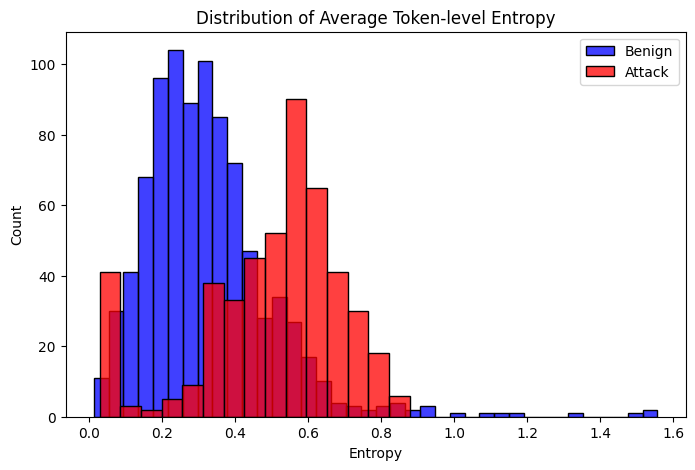

In [30]:
# Convert logits to probabilities
benign_probs = softmax(benign_logits, axis=-1)   # shape: [N_benign, seq_len, vocab_size]
attack_probs = softmax(attack_logits, axis=-1)

# Compute token-level entropies
benign_entropies = entropy(benign_probs, axis=-1)  # shape: [N_benign, seq_len]
attack_entropies = entropy(attack_probs, axis=-1)  # shape: [N_attack, seq_len]

# Summarize each sequence by the average entropy across tokens
benign_entropy_seq = benign_entropies.mean(axis=1)  # shape: [N_benign]
attack_entropy_seq = attack_entropies.mean(axis=1)  # shape: [N_attack]

plt.figure(figsize=(8,5))
sns.histplot(benign_entropy_seq, color="blue", label="Benign", kde=False)
sns.histplot(attack_entropy_seq, color="red", label="Attack", kde=False)
plt.title("Distribution of Average Token-level Entropy")
plt.xlabel("Entropy")
plt.ylabel("Count")
plt.legend()
plt.show()

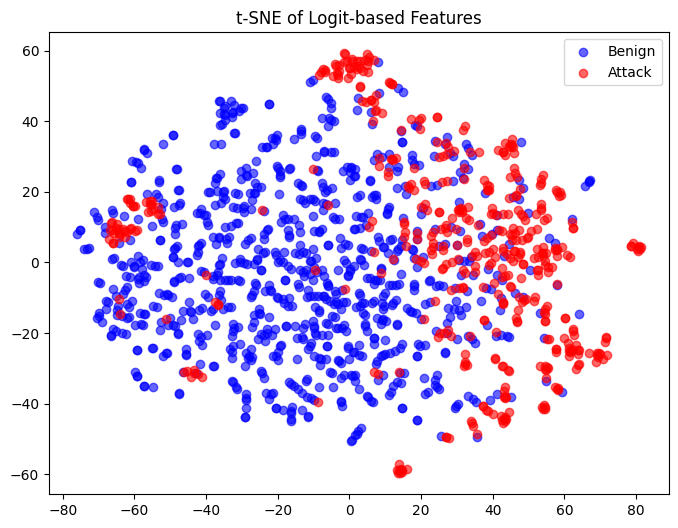

In [24]:
# If your benign_logits and attack_logits are raw logits,
# and you prefer to visualize negative log probabilities or something else,
# insert that transformation before flattening. For example:
#benign_logits = -np.log(softmax(benign_logits, axis=-1))
#attack_logits = -np.log(softmax(attack_logits, axis=-1))

# 1. Flatten each sample so that each row is a feature vector
#    If shape is [N, seq_len, vocab_size], this reshapes to [N, seq_len*vocab_size].
benign_feats = benign_logits.reshape(benign_logits.shape[0], -1)
attack_feats = attack_logits.reshape(attack_logits.shape[0], -1)

# 2. Create a single array for t-SNE
X = np.concatenate([benign_feats, attack_feats], axis=0)

# Create labels: 0 for benign, 1 for attack
y = np.concatenate([
    np.zeros(benign_feats.shape[0]), 
    np.ones(attack_feats.shape[0])]
)

# 3. Apply t-SNE
tsne = TSNE(n_components=2, perplexity=10)
X_2d = tsne.fit_transform(X)  # shape: [N_total, 2]

# 4. Plot
plt.figure(figsize=(8,6))
plt.scatter(
    X_2d[y == 0, 0], 
    X_2d[y == 0, 1],
    c="blue", alpha=0.6, label="Benign"
)
plt.scatter(
    X_2d[y == 1, 0],
    X_2d[y == 1, 1],
    c="red", alpha=0.6, label="Attack"
)
plt.title("t-SNE of Logit-based Features")
plt.legend()
plt.show()

C:\Users\nrahm\AppData\Local\Temp\ipykernel_42164\652134300.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=labels, y=all_data, palette=["blue", "red"])


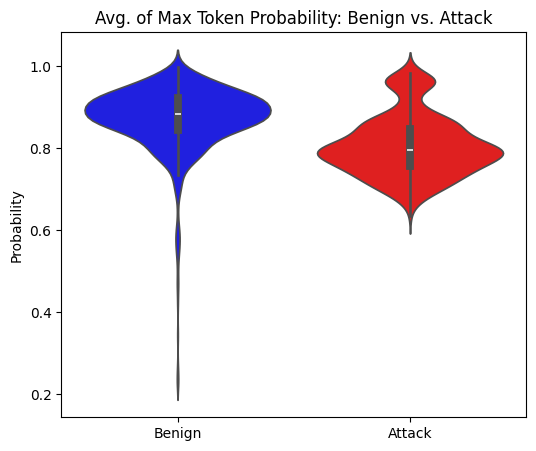

In [28]:
# Suppose you keep the top k logits for each token
# already in shape [N, seq_len, k].
# If you have the full vocab, adapt accordingly.

# Convert to probabilities if not already
benign_probs = softmax(benign_logits, axis=-1)  # shape [N, seq_len, k]
attack_probs = softmax(attack_logits, axis=-1)

# For each token, find max prob among the k candidates
benign_max_prob = benign_probs.max(axis=-1)  # shape [N, seq_len]
attack_max_prob = attack_probs.max(axis=-1)

# Summarize (e.g., average across tokens)
benign_max_prob_seq = benign_max_prob.mean(axis=1)
attack_max_prob_seq = attack_max_prob.mean(axis=1)

all_data = np.concatenate([benign_max_prob_seq, attack_max_prob_seq])
labels = ["Benign"] * len(benign_max_prob_seq) + ["Attack"] * len(attack_max_prob_seq)

plt.figure(figsize=(6,5))
sns.violinplot(x=labels, y=all_data, palette=["blue", "red"])
plt.title("Avg. of Max Token Probability: Benign vs. Attack")
plt.ylabel("Probability")
plt.show()


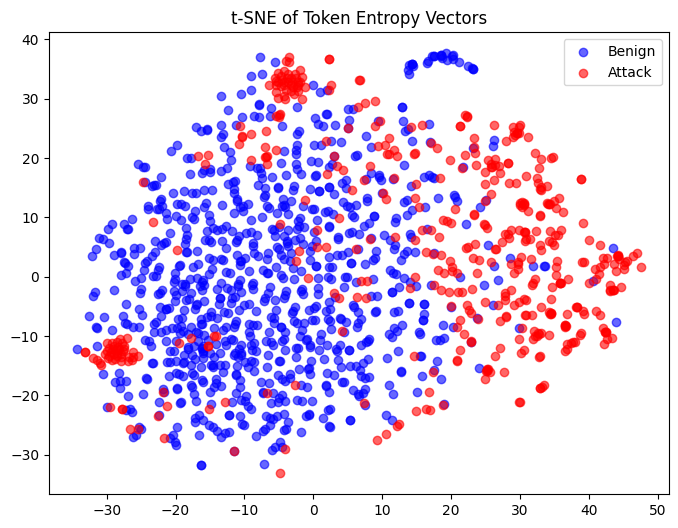

In [34]:
from sklearn.manifold import TSNE

# Suppose benign_ent shape: [N_benign, seq_len]
# We'll just flatten that to [N_benign, seq_len]
benign_ent_flat = benign_entropies # or benign_ent.reshape(benign_ent.shape[0], -1)
attack_ent_flat = attack_entropies

X = np.concatenate([benign_ent_flat, attack_ent_flat], axis=0)
y = np.concatenate([
    np.zeros(benign_ent_flat.shape[0]),
    np.ones(attack_ent_flat.shape[0])
])

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[y==0,0], X_2d[y==0,1], color="blue", alpha=0.6, label="Benign")
plt.scatter(X_2d[y==1,0], X_2d[y==1,1], color="red", alpha=0.6, label="Attack")
plt.legend()
plt.title("t-SNE of Token Entropy Vectors")
plt.show()